모든 내용은 아래 홈피 참고 
https://tensorflow.blog/2016/04/28/first-contact-with-tensorflow/

## 2. 선형회귀분석
## 2.1 

In [9]:
import numpy as np

In [2]:
num_points = 1000
vectors_set = []
for i in xrange(num_points): #python3 에서는 xrange 대신 range사용 
    x1 = np.random.normal(0.0, 0.55)
    y1 = x1*0.1+0.3+np.random.normal(0.0, 0.03)
    vectors_set.append([x1,y1])
x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]

/home/adioshun/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


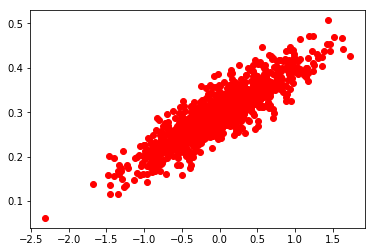

In [4]:
import matplotlib.pyplot as plt
plt.plot(x_data, y_data, 'ro')
plt.show()

### 2.2 비용함수와 경사 하강법 알고리즘

In [5]:
import tensorflow as tf

In [9]:
W = tf.Variable(tf.random_uniform([1], -1,10.))
b = tf.Variable(tf.zeros([1]))
y = W*x_data + b

In [10]:
loss = tf.reduce_mean(tf.square(y-y_data))

In [11]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

In [21]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for step in xrange(8):
    sess.run(train)
    
print step, sess.run(W), sess.run(b), sess.run(loss)

7 [ 0.24370448] [ 0.30077815] 0.00732936


In [2]:
plt.plot(x_data, y_data, 'ro')
plt.plot(x_data, sess.run(W)*x_data + sess.run(b))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'plt' is not defined

## 3. Clustering 
### 3.1 기본 자료 구조: 텐서
* 텐서 : 동적 크기를 가지는 다차원 데이터 배열(문자, 숫자등 정적 자료)
* 랭크 : 배열의 차원 나타냄 (0=스칼라, 1=벡터, 2=행렬)

### 3.2 텐서플로의 데이터 저장소
#### A. 데이터 파일에서 얻기 
#### B. 상수나 변수로 미리 로드
* tf.constant()를 이용한 `상수` 생성
* tf.variable()를 이용한 `변수` 생성

> 변수를 사용하려면 `run()`함수 구동전에 __반드시__초기화 하여함 `tf.initialize_all_variables()`

#### C. 파이손 코드로 작성해 제공하기 
* 심볼릭 변수(palceholder())사용
`a = tf.placeholder("float")`

### 3.3 k-평균 알고리즘

#### A. 알고리즘에서 사용할 데이터 생성 및 확인

In [1]:
import numpy as np
num_points = 2000
vectors_set = []

for i in xrange(num_points):
    if np.random.random()> 0.5:
        vectors_set.append([np.random.normal(0.0,0.9),np.random.normal(0.0,0.9)])
    else:
        vectors_set.append([np.random.normal(3.0,0.5),np.random.normal(1.0,0.5)])

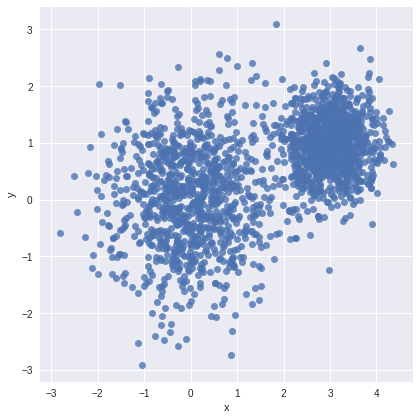

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns #conda install seaborn

df = pd.DataFrame({"x":[v[0] for v in vectors_set],
                   "y":[v[1] for v in vectors_set]})

sns.lmplot("x","y", data=df, fit_reg=False, size=6)

plt.show()

#### B. 텐서플로우를 이용한 그룹화

In [12]:
import tensorflow as tf
vectors = tf.constant(vectors_set)
k = 4

# slice() 메트릭스를 자른다, 첫번째는 소스 메트릭스, 두번재는 시작 주소, 세번째는 끝 메트릭스 # -1은 최대 길이
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0],[k,-1])) 

# 이후 연산시 두 텐서가 모두 2차원이지만 1차원의 크기가 다른 문제(2,000 vs. 4) 해결의해 차원 추가 
expanded_vectors = tf.expand_dims(vectors, 0) # 첫번째 차원 추가(D0)
expanded_centroides = tf.expand_dims(centroides,1) # 두번째 차원 추가(D1)

vectors.get_shape()
expanded_vectors.get_shape()


TensorShape([Dimension(1), Dimension(2000), Dimension(2)])

In [17]:
# 유클리드 제곱거리
assignments = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroides)),2),0)
# tf.sub() : 뺄셈
# tf.square() : 제곱을 계산, cf. tf.sqrt = 제곱근을 계산
# tf.reduce_sum() : 지정된 차원을 따라 원소들을 더한다. 
# tf.argmin() : 지정된 차원에서 가장 작은 값의 원소가 있는 인덱스를 리턴

In [18]:
# 새롭게 그룹화 하면서 새로운 중심을 다시계산 
means = tf.concat(0, [tf.reduce_mean(tf.gather(vectors, tf.reshape(tf.where(tf.equal(assignments, c)),[1,-1])),reduction_indices=[1]) for c in xrange(k)])
# tf.equal() : Returns the truth value of (x == y) element-wise.
# tf.where() : Returns locations of true values in a boolean tensor.
# tf.reshape() : 텐서의 원소는 그대로 유지하면서 텐서의 구조를 바꾼다. 
# tf.gather() : 주어진 인섹스에 따라 텐서의 원소를 모은다
# tf.reduce_mean() : 지정된 차원을 따라 평균을 계산한다. 
# tf.concat() : 한 차원을 기준으로 텐서를 이어 붙인다.


In [19]:
update_centroides = tf.assign(centroides, means)

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in xrange(100):
        _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])
    print centroid_values

[[-0.07362854 -0.77066123]
 [ 3.26145506  1.08977711]
 [-0.21091481  0.69347483]
 [ 2.30035162  0.67147851]]
